# The search for dark vessels: AIS / ship detection fusion workflow

All ships above a certain size are by law required to use an AIS (Automated Identification System) transponder and
are therefore trackable at all times wherever they go. A ship without such a signal is called a "dark vessel". While
there are not always sinister reasons for this behaviour this quite often indicates that something "fishy" is going
on. Not surprisingly there are many organisations which are interested in this kind of information.

In the following we show how dark vessels can be identified by combining a Machine Learning-based algorithm working on
satellite images (provided by Airbus, see [ship detection block on UP42 marketplace]( https://marketplace.up42.com/block/79e3e48c-d65f-4528-a6d4-e8d20fecc93c) for more details) with AIS signals (provided by [ExactEarth on UP42](https://marketplace.up42.com/block/54217695-73f4-4528-a575-a429e9af6568)).

The workflow consists of the following steps:

- Get SPOT imagery for the given AOI
- Execute format conversion, CRS conversion, tiling, ship detection and ship identification blocks via parallel jobs
- Visualize the results

To run the example costs around 8,000 UP42 credits. *Disclaimer* In a real-world scenario we would only use SPOT Streaming data as input for the shop detection and identification. In the context of this analysis we are using SPOT Download data so we can download it (which the Streaming data license does not allow) and produce attractive visualisations. Using streming data would result in a much lower number of credits.

## Setup

Import required libraries

In [258]:
import up42
import geopandas as gpd
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from shapely.geometry import box
import geojson

Configure areas of interest

In [259]:
aoi_sby = {"type":"FeatureCollection","features":[{"type":"Feature","properties":{},
                "geometry":{"type":"Polygon","coordinates":[[[112.713691,-7.183133],
                                                             [112.73185,-7.183133],
                                                             [112.73185,-7.172643],
                                                             [112.713691,-7.172643],
                                                             [112.713691,-7.183133]]]}}]}
aoi_gib = {"type":"FeatureCollection","features":[{"type":"Feature","properties":{},
                "geometry":{"type":"Polygon","coordinates":[[[-5.370973,36.115663],
                                                             [-5.348018,36.115663],
                                                             [-5.355756,36.141326],
                                                             [-5.3598,36.147976],
                                                             [-5.370531,36.148606],
                                                             [-5.370973,36.115663]]]}}]}
aois = [{'title': 'SBY', 'geometry': aoi_sby},
        {'title': 'GIB', 'geometry': aoi_gib}]

Authenticate with UP42

In [260]:
#up42.authenticate(project_id="123", project_api_key="456")
up42.authenticate(cfg_file="config.json")
up42.settings(log=False)

# Catalog Search

Search cloudfree SPOT images for the two aois and visualise the quicklooks.


---------SBY---------



100%|██████████| 3/3 [00:02<00:00,  1.50it/s]


,geometry,id,acquisitionDate,constellation,providerName,blockNames,cloudCoverage,up42:usageType,providerProperties,scene_id
0,"POLYGON ((112.56527 -6.78011, 112.56507 -7.320...",53341a16-7294-4cfd-bcc8-de40cace639f,2020-09-29T02:20:15Z,SPOT,oneatlas,"[oneatlas-spot-fullscene, oneatlas-spot-aoicli...",1.22655,"[DATA, ANALYTICS]",{'acquisitionDate': '2020-09-29T02:20:15.624Z'...,DS_SPOT6_202009290220156_FR1_FR1_FR1_FR1_E113S...
1,"POLYGON ((112.58667 -6.76592, 112.58758 -7.301...",66c48450-288e-4e19-8829-b44c121a8e79,2019-11-09T02:22:38Z,SPOT,oneatlas,"[oneatlas-spot-fullscene, oneatlas-spot-aoicli...",2.31000,"[DATA, ANALYTICS]","{'commercialReference': 'SO19050079', 'acquisi...",DS_SPOT7_201911090222385_FR1_FR1_SV1_SV1_E113S...
2,"POLYGON ((112.54476 -6.75036, 113.19278 -6.751...",94d9ce84-c35c-467a-8732-3a9bfbe725b7,2019-05-25T02:12:44Z,SPOT,oneatlas,"[oneatlas-spot-fullscene, oneatlas-spot-aoicli...",4.08000,"[DATA, ANALYTICS]","{'commercialReference': 'SO19018464', 'acquisi...",DS_SPOT7_201905250212445_FR1_FR1_SV1_SV1_E113S...


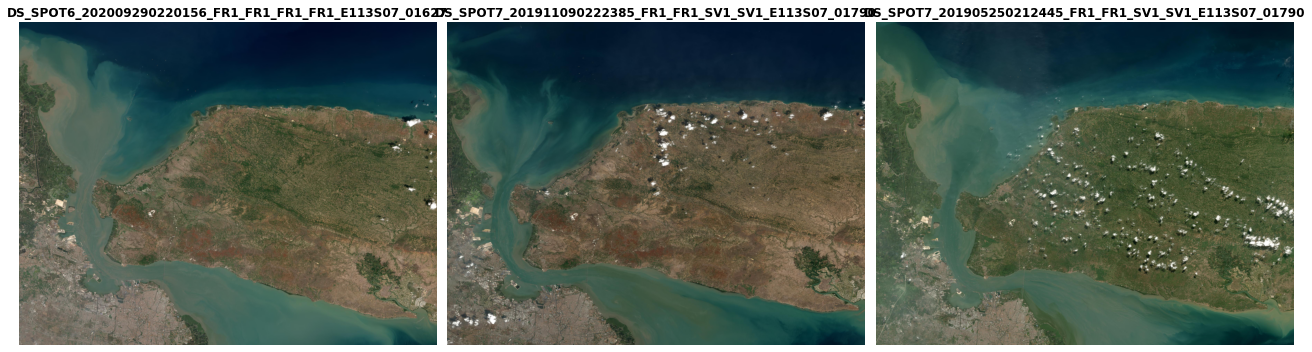


---------GIB---------



100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


,geometry,id,acquisitionDate,constellation,providerName,blockNames,cloudCoverage,up42:usageType,providerProperties,scene_id
0,"POLYGON ((-5.79032 36.97194, -5.78606 35.94822...",d0e3f2d1-446d-4363-a16e-00b7fbf78010,2020-07-10T10:47:55Z,SPOT,oneatlas,"[oneatlas-spot-fullscene, oneatlas-spot-aoicli...",0.0,"[DATA, ANALYTICS]",{'acquisitionDate': '2020-07-10T10:47:55.249Z'...,DS_SPOT7_202007101047552_FR1_FR1_FR1_FR1_W005N...
1,"POLYGON ((-5.77699 36.26248, -5.77327 35.95973...",70c73d86-0e25-4eb8-8967-0a047252262f,2020-03-10T10:29:23Z,SPOT,oneatlas,"[oneatlas-spot-fullscene, oneatlas-spot-aoicli...",0.0,"[DATA, ANALYTICS]","{'acquisitionDate': '2020-03-10T10:29:23Z', 'q...",DS_SPOT6_202003101037200_FR1_FR1_FR1_FR1_W005N...


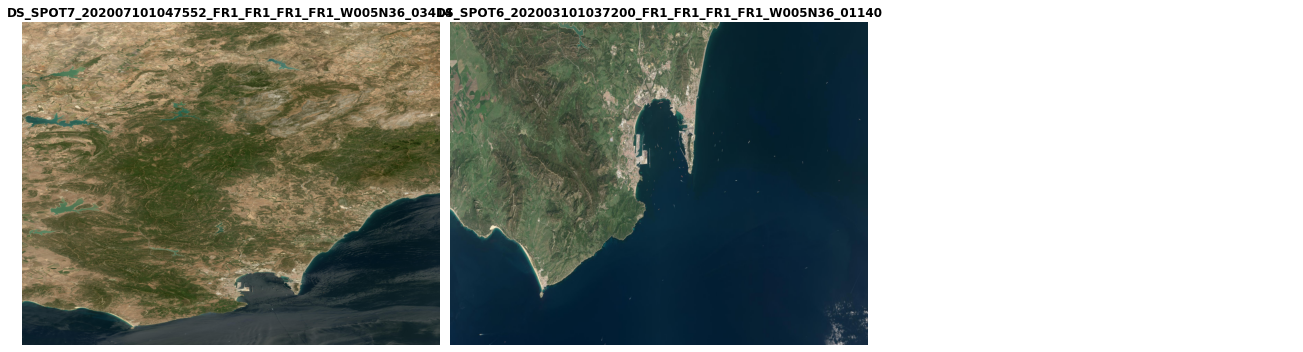

In [261]:
catalog = up42.initialize_catalog()


for aoi in aois:
    print("\n---------" + aoi["title"] + "---------\n")
    search_paramaters = catalog.construct_parameters(geometry=aoi['geometry'], 
                                                     start_date="2019-01-01",
                                                     end_date="2020-12-31",
                                                     sensors=["spot"],
                                                     max_cloudcover=5,
                                                     sortby="acquisitionDate",
                                                     ascending=False,
                                                     limit=3)
    search_results = catalog.search(search_paramaters)
    
    # Download & Visualise quicklooks
    catalog.download_quicklooks(image_ids=search_results.id.to_list(), sensor="spot")
    display(search_results.head())
    catalog.plot_quicklooks(figsize=(18,5), titles=search_results.scene_id.to_list())

    # Select least cloud scene for further workflow
    aoi["scene_id"] = search_results.scene_id.to_list()[0]

In [213]:
# Optional: Select ideal scenes manually
aois[0]["scene_id"] = "DS_SPOT6_202009290220156_FR1_FR1_FR1_FR1_E113S07_01627"
aois[1]["scene_id"] = "DS_SPOT7_202007101047552_FR1_FR1_FR1_FR1_W005N36_03414"

# Run ship identification workflow on selected images

In [214]:
up42.settings(log=True)
project = up42.initialize_project()

# Increase the parallel job limit for the project.
#project.update_project_settings(max_concurrent_jobs=10)

2020-12-02 15:57:21,557 - Initialized Project(name: Dark vessels, project_id: 2db3c170-7772-4bef-9344-2182421e2938, description: Project used for the AIS webinar, createdAt: 2020-11-25T08:08:47.717742Z)


Create or update a workflow for the ship identification

In [238]:
workflow = project.create_workflow("Ship identification download", use_existing=True)

2020-12-03 09:02:20,843 - Getting existing workflows in project ...
2020-12-03 09:02:21,309 - Got 4 workflows for project 2db3c170-7772-4bef-9344-2182421e2938.
100%|██████████| 4/4 [00:01<00:00,  2.89it/s]
2020-12-03 09:02:22,704 - Using existing workflow: Ship identification download - 52a390e1-d3de-4140-ae74-2ea9eeb4acfc


Add or update workflows tasks

In [240]:
input_tasks= ['oneatlas-spot-display', 'data-conversion-dimap', 'crs-conversion', 'tiling', 'ship-detection', 'ship-identification']
workflow.add_workflow_tasks(input_tasks=input_tasks)
workflow

2020-12-03 09:04:20,504 - Added tasks to workflow: [{'name': 'oneatlas-spot-display:1', 'parentName': None, 'blockId': '3e24ed57-b07f-4d44-9957-5d5c0a457239'}, {'name': 'data-conversion-dimap:1', 'parentName': 'oneatlas-spot-display:1', 'blockId': 'c94bb4cd-8ee2-40df-ba76-d332b8f48c6a'}, {'name': 'crs-conversion:1', 'parentName': 'data-conversion-dimap:1', 'blockId': '30f20bac-7499-4159-a4f3-38188a6e33e0'}, {'name': 'tiling:1', 'parentName': 'crs-conversion:1', 'blockId': '3e146dd6-2b67-4d6e-a422-bb3d973e32ff'}, {'name': 'ship-detection:1', 'parentName': 'tiling:1', 'blockId': '79e3e48c-d65f-4528-a6d4-e8d20fecc93c'}, {'name': 'ship-identification:1', 'parentName': 'ship-detection:1', 'blockId': '54217695-73f4-4528-a575-a429e9af6568'}]


Workflow(name: Ship identification download, workflow_id: 52a390e1-d3de-4140-ae74-2ea9eeb4acfc, description: , createdAt: 2020-12-02T15:31:26.459058Z, project_id: 2db3c170-7772-4bef-9344-2182421e2938, workflow_tasks: {'oneatlas-spot-display:1': '1.0.0', 'data-conversion-dimap:1': '1.3.1', 'crs-conversion:1': '2.1.2', 'tiling:1': '2.2.3', 'ship-detection:1': '5.2.0-public', 'ship-identification:1': '2.3.1'}

## Run jobs in parallel

Construct workflow input parameters & run jobs

In [242]:
input_parameters_list = []

for aoi in aois:
    input_parameters = workflow.construct_parameters(geometry=aoi['geometry'], 
                                                     geometry_operation="bbox", 
                                                     scene_ids=[aoi["scene_id"]])
    input_parameters['crs-conversion:1']['output_epsg_code']  = 3857
    input_parameters_list.append(input_parameters)

input_parameters_list

[{'oneatlas-spot-display:1': {'limit': 1,
   'max_cloud_cover': 100,
   'ids': ['DS_SPOT6_202009290220156_FR1_FR1_FR1_FR1_E113S07_01627'],
   'bbox': [112.713691, -7.183133, 112.73185, -7.172643]},
  'data-conversion-dimap:1': {'ms': True, 'pan': False, 'clip_to_aoi': False},
  'crs-conversion:1': {'resampling_method': 'cubic', 'output_epsg_code': 3857},
  'tiling:1': {'tile_width': 768,
   'tile_height': 768,
   'match_extents': False,
   'output_prefix': '',
   'augmentation_factor': 1,
   'discard_empty_tiles': True},
  'ship-detection:1': {},
  'ship-identification:1': {'minutes': 15}},
 {'oneatlas-spot-display:1': {'limit': 1,
   'max_cloud_cover': 100,
   'ids': ['DS_SPOT7_202007101047552_FR1_FR1_FR1_FR1_W005N36_03414'],
   'bbox': [-5.370973, 36.115663, -5.348018, 36.148606]},
  'data-conversion-dimap:1': {'ms': True, 'pan': False, 'clip_to_aoi': False},
  'crs-conversion:1': {'resampling_method': 'cubic', 'output_epsg_code': 3857},
  'tiling:1': {'tile_width': 768,
   'tile_hei

In [243]:
jobs = workflow.run_jobs_parallel(input_parameters_list=input_parameters_list)

2020-12-03 09:07:44,028 - Selected input_parameters: {'oneatlas-spot-display:1': {'limit': 1, 'max_cloud_cover': 100, 'ids': ['DS_SPOT6_202009290220156_FR1_FR1_FR1_FR1_E113S07_01627'], 'bbox': [112.713691, -7.183133, 112.73185, -7.172643]}, 'data-conversion-dimap:1': {'ms': True, 'pan': False, 'clip_to_aoi': False}, 'crs-conversion:1': {'resampling_method': 'cubic', 'output_epsg_code': 3857}, 'tiling:1': {'tile_width': 768, 'tile_height': 768, 'match_extents': False, 'output_prefix': '', 'augmentation_factor': 1, 'discard_empty_tiles': True}, 'ship-detection:1': {}, 'ship-identification:1': {'minutes': 15}}.
2020-12-03 09:07:45,778 - Created and running new job: 008eed01-f188-4402-8bba-c71adedc1311
2020-12-03 09:07:46,132 - Selected input_parameters: {'oneatlas-spot-display:1': {'limit': 1, 'max_cloud_cover': 100, 'ids': ['DS_SPOT7_202007101047552_FR1_FR1_FR1_FR1_W005N36_03414'], 'bbox': [-5.370973, 36.115663, -5.348018, 36.148606]}, 'data-conversion-dimap:1': {'ms': True, 'pan': False

# Download & Visualise results

In [244]:
jobtask = job.get_jobtasks()

2020-12-03 09:22:47,721 - Getting job tasks: 99c238b8-d6f2-4c3a-ad29-8ec6cee6c344


In [245]:
data_results_paths, detection_results, identification_results = [], [], []
for job in jobs:
    _, _, data_task, _, detection_task, identification_task = job.get_jobtasks()
    data_paths = data_task.download_results()
    data_results_paths.append([p for p in data_paths if p.endswith(".tif")])    
    detection_results.append(detection_task.get_results_json())
    identification_paths = identification_task.download_results()
    geojson_path = [p for p in identification_paths if p.endswith(".geojson")][0]
    with open(geojson_path) as f:
        gj = geojson.load(f)
    identification_results.append(gj)

2020-12-03 09:26:06,471 - Getting job tasks: 008eed01-f188-4402-8bba-c71adedc1311
2020-12-03 09:26:09,254 - Downloading results of jobtask 3688704c-efbf-4cd7-87d3-640509a1d25f
2020-12-03 09:26:09,258 - Download directory: /Users/markus.mueller/projects/up42-py/examples/project_2db3c170-7772-4bef-9344-2182421e2938/job_008eed01-f188-4402-8bba-c71adedc1311/jobtask_3688704c-efbf-4cd7-87d3-640509a1d25f
2307it [00:00, 219795.10it/s]
2020-12-03 09:26:10,470 - Download successful of 2 files to output_directory '/Users/markus.mueller/projects/up42-py/examples/project_2db3c170-7772-4bef-9344-2182421e2938/job_008eed01-f188-4402-8bba-c71adedc1311/jobtask_3688704c-efbf-4cd7-87d3-640509a1d25f': ['22ea4dc7-bb31-44c8-9845-25a3d80cff4f_pms.tif', 'data.json']
2020-12-03 09:26:11,018 - Retrieved 48 features.
2020-12-03 09:26:11,019 - Downloading results of jobtask ad9214d7-7b94-48dd-bcb1-aa560ae03656
2020-12-03 09:26:11,020 - Download directory: /Users/markus.mueller/projects/up42-py/examples/project_2db

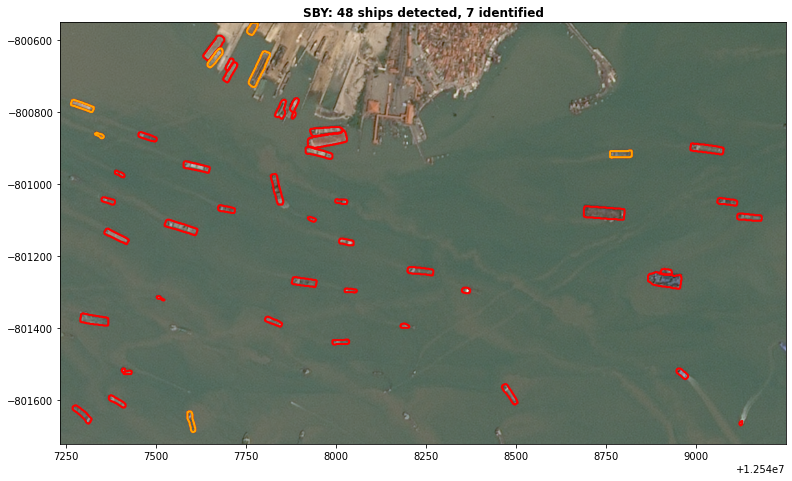

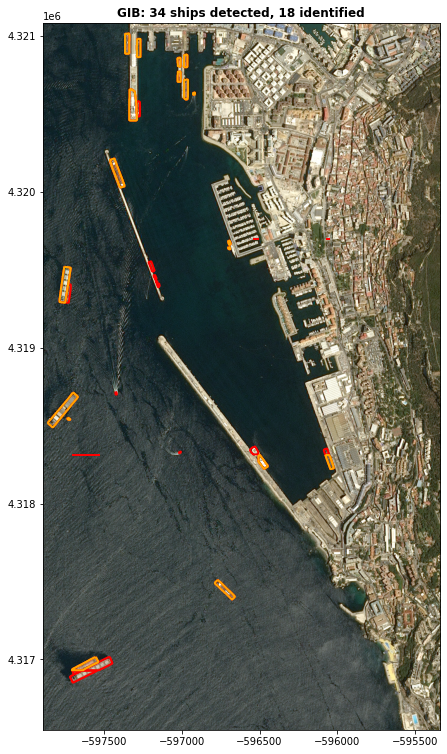

In [251]:
for i, (paths, detection, identification) in enumerate(zip(data_results_paths, detection_results, identification_results)):
    with rasterio.open(paths[0]) as src:
        fig, ax = plt.subplots(figsize=(13, 13))

        ships = gpd.GeoDataFrame.from_features(detection, crs="epsg:4326")
        ships = ships.to_crs(epsg=3857)
        ships_ais = gpd.GeoDataFrame.from_features(identification, crs="urn:ogc:def:crs:OGC:1.3:CRS84")
        ships_ais = ships_ais.to_crs(epsg=3857)
        
        # Exclude ships without a vessel name
        ships_ais = ships_ais[ships_ais["vessel_name"].notnull()]
   
        ships.plot(ax=ax, facecolor=(0,0,0,0), edgecolor='red', linewidth=2)
        ships_ais.plot(ax=ax, facecolor=(0,0,0,0), edgecolor='orange', linewidth=2)
        
        show(src.read((1, 2, 3)), transform=src.transform, ax=ax, title=
             f"{aois[i]['title']}: {ships.shape[0]} ships detected, {len(ships_ais.index)} identified")
        
        plt.show()

# Summary

In the above visualisations all ships identified using AIS are shown in orange, while those unidentified in red. This
does not necessarily indicate that those red shops are doing anything illegal; they simply might be too small or the AIS signal could not be found because the time window used for searching is too small. The point is that the red ships are candidate dark vessels - any real-world analysis would need to dive deeper. The analyses are only there to showcase how such an analysis works and we are using the two ports for just that - we don't want to imply at all that someting something fishy is going on there.